# CLUSTERING ML

L'objectif de ce notebook est de voir si des methodes ML pouvaient détecter les régimes de Trend et donc permettre d'avoir un meilleur alpha qu'avec les outils/conditions techniques (propriétaires) utilisés actuellement.

Rien a changé en ce qui concerne les hypotheses et les features.

## Connexion Google Drive/Colab

Etant doté d'un ordinateur avec peu de ram, il était impossible de tout runner sur vscode. Cependant, c'est plus facile/rapide pour faire des tests dans le devcontainers. Mais tout crash car cela prend toute la ram

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Installation de Talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!sudo make install
!pip install TA-Lib
!pip install freqtrade
!pip install -U vectorbt[full]

import os
os.kill(os.getpid(), 9)

--2024-10-17 14:24:00--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-10-17 14:24:00--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://altushost-swe.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-10-17 14:24:00--  http://altushost-swe.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.4/497.4 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 40.7 MB/s eta 0:00

## Librairies

In [2]:
#Rajout du script Helpers
import sys
sys.path.append('/content/drive/My Drive/convedgences')

In [3]:
from pathlib import Path
import helpers as bt_helpers

import vectorbt as vbt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from tqdm import notebook
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# import statsmodels.api as sm
# import statsmodels.tsa.stattools as ts
import warnings
from sklearn.cluster import DBSCAN

In [4]:
#car c'est un peu sale d'avoir ces warnings quand le code tourne
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
data_directory = "/content/drive/My Drive/convedgences/data/data_v4"

min_sharpe_to_be_eligible = -10

In [6]:
data_directory = Path(data_directory)

In [7]:
slider_tf = bt_helpers.tf_slider()
display(slider_tf.widget)
fee_selector = bt_helpers.create_fee_selector()
display(fee_selector.widget)

**Here you can change the markets you work with.**

In [8]:
pairs = [
    "BNB/USDT:USDT",
    "SOL/USDT:USDT",
    "XRP/USDT:USDT",
    "DOGE/USDT:USDT",
    "ADA/USDT:USDT",
    "AVAX/USDT:USDT",
    "TON/USDT:USDT",
    "BCH/USDT:USDT",
    "DOT/USDT:USDT",
    "LINK/USDT:USDT",
    "TRX/USDT:USDT",
    "UNI/USDT:USDT",
    "ICP/USDT:USDT",
    "LTC/USDT:USDT",
    "NEAR/USDT:USDT",
    "APT/USDT:USDT",
    "ETC/USDT:USDT",
    "STX/USDT:USDT",
    "FIL/USDT:USDT",
    "ATOM/USDT:USDT",
    "IMX/USDT:USDT",
    "ARB/USDT:USDT",
    "WIF/USDT:USDT",
    "XLM/USDT:USDT",
    "MKR/USDT:USDT",
    "HBAR/USDT:USDT",
    "GRT/USDT:USDT",
    "OP/USDT:USDT",
    "VET/USDT:USDT",
    "KAS/USDT:USDT",
    "INJ/USDT:USDT",
    "FET/USDT:USDT",
    "RUNE/USDT:USDT",
    "THETA/USDT:USDT",
    "FTM/USDT:USDT",
    "LDO/USDT:USDT",
    "XMR/USDT:USDT",
    "AR/USDT:USDT",
    "SUI/USDT:USDT",
    "W/USDT:USDT",
    "GALA/USDT:USDT",
    "TIA/USDT:USDT",
    "JUP/USDT:USDT",
    "SEI/USDT:USDT",
    "ALGO/USDT:USDT",
    "BSV/USDT:USDT",
    "FLOW/USDT:USDT",
    "QNT/USDT:USDT",
    "AAVE/USDT:USDT",
    "ENA/USDT:USDT",
    "EGLD/USDT:USDT",
    "AGIX/USDT:USDT",
    "CFX/USDT:USDT",
    "DYDX/USDT:USDT",
    "STRK/USDT:USDT",
    "AXS/USDT:USDT",
    "SAND/USDT:USDT",
    "SNX/USDT:USDT",
    "PYTH/USDT:USDT",
    "CHZ/USDT:USDT",
    "XTZ/USDT:USDT",
    "ORDI/USDT:USDT",
    "WLD/USDT:USDT",
    "ONDO/USDT:USDT",
    "MINA/USDT:USDT",
    "EOS/USDT:USDT",
    "MANA/USDT:USDT",
    "APE/USDT:USDT",
    "NEO/USDT:USDT",
    "AXL/USDT:USDT",
    "KAVA/USDT:USDT",
    "IOTA/USDT:USDT",
    "CAKE/USDT:USDT",
    "JASMY/USDT:USDT",
    "KLAY/USDT:USDT",
    "BOME/USDT:USDT",
    "ROSE/USDT:USDT",
    "DYM/USDT:USDT",
    "CKB/USDT:USDT",
    "BLUR/USDT:USDT",
    "ILV/USDT:USDT",
    "WOO/USDT:USDT",
    "CRV/USDT:USDT",
    "MANTA/USDT:USDT",
    "IOTX/USDT:USDT",
    "OCEAN/USDT:USDT",
    "ASTR/USDT:USDT",
    "ALT/USDT:USDT",
    "ENJ/USDT:USDT",
    "SKL/USDT:USDT",
    "1INCH/USDT:USDT",
    "ETHFI/USDT:USDT",
    "ENS/USDT:USDT",
    "ZIL/USDT:USDT",
    "POLYX/USDT:USDT",
    "CELO/USDT:USDT",
    "GMT/USDT:USDT",
    "ZRX/USDT:USDT",
    "OM/USDT:USDT",
    "BICO/USDT:USDT",
    "ANKR/USDT:USDT",
    "RVN/USDT:USDT",
    "MEME/USDT:USDT",
    "FXS/USDT:USDT",
    "SUPER/USDT:USDT",
    "TWT/USDT:USDT",
    "HOT/USDT:USDT",
    "PENDLE/USDT:USDT",
    "GLM/USDT:USDT",
    "LPT/USDT:USDT",
    "JTO/USDT:USDT",
    "PIXEL/USDT:USDT",
    "COMP/USDT:USDT",
    "RSR/USDT:USDT",
    "ETHW/USDT:USDT",
    "METIS/USDT:USDT",
    "MASK/USDT:USDT",
    "ARKM/USDT:USDT",
    "QTUM/USDT:USDT",
]


In [13]:
fees = fee_selector.selected_fee
market_type = "futures"

time_frames = bt_helpers.interpolate_timeframes(slider_tf.selected_values[0], slider_tf.selected_values[1])

# Backtest

### Features Sélectionnées

Nous avons sélectionné les features qui faisaient sens dans la recherche des regimes de mean reversion et Trends.
1. RSI
2. Autocorrelation : L’autocorrélation sur une fenêtre glissante permet de mesurer la dépendance entre les valeurs successives des prix. Cela peut indiquer la persistance ou la cyclicité des retours, ce qui est utile pour le clustering des actifs ayant des comportements autocorrélés
3. Is_stationary : Une serie stationaire peut indiquer un retour à la moyenne lorsque l'actif n'est pas dans son range habituel. Si la serie n'est pas
   stationaire, cela peut indiquer une tendance. C'etait trop long de faire un test de stationarité style AdFuller ou KPSS, c'est une alternative ici
4. Volatilité
5. Kurtosis et Skew: Ces deux indicateurs sont essentiels pour capturer les asymétries et les queues épaisses dans la distribution des retours, respectivement. C'est un choix pour mieux comprendre les comportements extrêmes et non normaux des actifs.
6. EMA
7. Returns: Rendements

Nous avions également pensé rajouter le HURST Component, il permet de savoir en fonction de son niveau si notre serie est un mouvement brownien, en mean reversion ou en tendance. Cependant cela mettait trop de temps à compute.....

L'interet du modèle Kmeans, est qu'il est facile à comprendre. L'objectif du Kmeans etant de regrouper les actifs qui se ressemblent. C'est un modèle qui se base sur la moyenne. Chaque actif d'un cluster sont supposés etre en moyenne similaires. Les methodes actuelles utilisés dans le trading, ne le font peut-etre pas si rapidement...

### Parametrage de l'algo

Suite à nos tests sur les timesframes, nous avons estimé que ces valeurs étaient les meilleures, nous les avons donc mise en default.

1. n_clusters = 5
   Nous avons constaté que le nombre ideal de clusters étaient de 5, c'etait le nombre de cluster qui minimisait l'inertie (la difference de distance      entre les actifs d'un cluster). On choisit le nombre de cluster qui va minimiser notre inertie (distance entre les points et leur centroide)

3. max_iter=150
   Ce paramètre contrôle le nombre maximal d'itérations que l'algorithme K-means effectuera pendant le processus de clustering. Max_iter est un "garde-    fou" qui assure que l'algorithme s'arrête après un certain nombre d'essais, même s'il n'a pas trouvé la solution optimale.

4. random_state=100
   Ce paramètre contrôle la génération des valeurs aléatoires utilisées par l'algorithme, en particulier pour l'initialisation des centroïdes.

5. algorithm="elkan"
   Ce paramètre détermine la variante de l'algorithme K-means utilisée pour le calcul

### Fonctions

In [14]:
from typing import Dict, List, Any


RSI = vbt.IndicatorFactory.from_pandas_ta("RSI")
ADX = vbt.IndicatorFactory.from_talib("ADX")
ATR = vbt.IndicatorFactory.from_talib("ATR")
SMA = vbt.IndicatorFactory.from_talib("SMA")
EMA = vbt.IndicatorFactory.from_talib("EMA")
TRANGE = vbt.IndicatorFactory.from_talib("TRANGE")
ER = vbt.IndicatorFactory.from_pandas_ta("ER")
VAR = vbt.IndicatorFactory.from_pandas_ta("VARIANCE")
MAX_vbt = vbt.IndicatorFactory.from_talib("MAX")
MIN_vbt = vbt.IndicatorFactory.from_talib("MIN")
LOG_RETURN = vbt.IndicatorFactory.from_pandas_ta("LOG_RETURN")
SKEW = vbt.IndicatorFactory.from_pandas_ta("SKEW")
KURTOSIS = vbt.IndicatorFactory.from_pandas_ta("KURTOSIS")

strat_names = ["Naive", "Cluster"]


def summary_stats_multidim(data):
    return np.column_stack([np.nanmean(data, axis=0)])


periods_per_day = {"1d": 1, "12h": 2, "8h": 3, "6h": 4, "4h": 6, "2h": 12, "1h": 24}


def time_window_to_periods(time_window_in_days, timeframe):
    return int(time_window_in_days * periods_per_day[timeframe])


def comp_pfs(
    dataframe: pd.DataFrame, time_frame: str, strat_pairs: dict[str, list[str]], window_size=7, n_clusters=5
) -> dict[Any, dict[str, Any]]:
    # ================================================== FEATURES COMPUTATION======================================================================

    accurate_window = time_window_to_periods(window_size, time_frame)
    rsi2 = RSI.run(dataframe["close"], lenght=accurate_window)
    autocorr = (
        dataframe["close"].rolling(window=accurate_window).apply(lambda x: np.corrcoef(x[:-1], x[1:])[0, 1], raw=True)
    )
    log_returns = LOG_RETURN.run(dataframe["close"]).logret

    variance = VAR.run(log_returns, lenght=accurate_window).var
    max_vbt = MAX_vbt.run(variance, timeperiod=accurate_window)
    min_vbt = MIN_vbt.run(variance, timeperiod=accurate_window)

    fast_window = time_window_to_periods(10, time_frame)
    slow_window = time_window_to_periods(30, time_frame)
    ema_fast = EMA.run(log_returns, timeperiod=fast_window).real.to_numpy()
    ema_slow = EMA.run(log_returns, timeperiod=slow_window).real.to_numpy()
    signal_fast_slow = ema_fast - ema_slow

    is_stationary_variance = (max_vbt.real - min_vbt.real) < 0.01

    trading_days_per_year = 252
    periods_per_year = trading_days_per_year * periods_per_day[time_frame]

    volatility = log_returns.rolling(window=accurate_window).std() * np.sqrt(periods_per_year)

    nb_tickers = dataframe["close"].shape[1]

    rolling_clusters = np.full((dataframe["close"].shape[0], nb_tickers), np.nan)
    rolling_returns = np.full(dataframe["close"].shape[0], np.nan)
    kurt = KURTOSIS.run(log_returns).kurt
    skew = SKEW.run(log_returns).skew
    ema_price = EMA.run(dataframe["close"].shift(), timeperiod=accurate_window).real

    # ============================================================SCALING PREPARATION=============================================================

    # Préparation des caractéristiques initiales pour le scaler
    initial_indices = range(accurate_window)
    initial_rsi_window = rsi2.rsi.to_numpy()[initial_indices, :]
    initial_autocorr_window = autocorr.to_numpy()[initial_indices, :]
    initial_is_stationary_variance_window = is_stationary_variance.to_numpy()[initial_indices, :]
    initial_log_returns_window = log_returns.to_numpy()[initial_indices, :]
    initial_ema_price_window = ema_price.to_numpy()[initial_indices, :]
    initial_kurt_window = kurt.to_numpy()[initial_indices, :]
    initial_skew_window = skew.to_numpy()[initial_indices, :]
    initial_volat_window = volatility.to_numpy()[initial_indices, :]

    # Calcul des caractéristiques initiales pour le scaler
    initial_features = np.column_stack(
        (
            np.nanmean(initial_rsi_window, axis=0),
            np.nanmean(initial_autocorr_window, axis=0),
            np.nanmean(initial_is_stationary_variance_window, axis=0),
            np.nanmean(initial_log_returns_window, axis=0),
            np.nanmean(initial_kurt_window, axis=0),
            np.nanmean(initial_skew_window, axis=0),
            np.nanmean(initial_volat_window, axis=0),
            np.nanmean(initial_ema_price_window, axis=0),
        )
    )

    # Remplacer les NaN par 0 dans les caractéristiques initiales
    initial_features = np.nan_to_num(initial_features, nan=0)

    # Création du scaler global basé sur les caractéristiques initiales. Le scaling est très important, si les echelles sont differentes, cela fausse les calculs de nos clusters
    scaler = StandardScaler()
    scaler.fit(initial_features)

    # ======================================================ROLLING CLUSTERING===================================================================

    kmeans = KMeans(n_clusters=n_clusters, max_iter=150, random_state=100, algorithm="elkan")

    for i in notebook.tqdm(range(accurate_window, len(dataframe["close"]))):
        rsi_window = rsi2.rsi.to_numpy()[i - accurate_window : i, :]
        autocorr_window = autocorr.to_numpy()[i - accurate_window : i, :]
        is_stationary_variance_window = is_stationary_variance.to_numpy()[i - accurate_window : i, :]
        log_returns_window = log_returns.to_numpy()[i - accurate_window : i, :]
        ema_price_window = ema_price.to_numpy()[i - accurate_window : i, :]

        signal_fast_slow = signal_fast_slow[i - accurate_window : i, :]
        kurt_window = kurt.to_numpy()[i - accurate_window : i, :]
        skew_window = skew.to_numpy()[i - accurate_window : i, :]

        features = np.column_stack(
            (
                np.nanmean(rsi_window, axis=0),
                np.nanmean(autocorr_window, axis=0),
                np.nanmean(is_stationary_variance_window, axis=0),
                np.nanmean(log_returns_window, axis=0),
                np.nanmean(kurt_window, axis=0),
                np.nanmean(skew_window, axis=0),
                np.nanmean(volatility, axis=0),
                np.nanmean(ema_price_window, axis=0),
            )
        )

        features = np.nan_to_num(features, nan=0)

        if np.isnan(features).any() or np.isinf(features).any():
            print(f"Skipping window at index {i} due to NaN or inf values")
            rolling_clusters[i, :] = np.nan
            continue

        # scaler = StandardScaler()
        features_scaled = scaler.transform(features)

        clusters = kmeans.fit_predict(features_scaled)

        rolling_clusters[i, :] = clusters

    dataframe["cluster"] = pd.DataFrame(
        data=rolling_clusters, index=dataframe["close"].index, columns=dataframe["close"].columns
    )

    # ============================================================ROLLING SHARPE PAR CLUSTERS=====================================================#

    # Calcul des retours pour chaque actif
    # les rendements arithmétiques peuvent mieux refléter les mouvements de prix réels observables.
    returns = dataframe["close"].pct_change()
    returns.index.name = "date"

    # Récupération des clusters
    clusters = dataframe["cluster"]
    clusters.index.name = "date"

    # Transformation des DataFrames en format long
    returns_melted = returns.reset_index().melt(id_vars=["date"], var_name="asset", value_name="return")
    clusters_melted = clusters.reset_index().melt(id_vars=["date"], var_name="asset", value_name="cluster")

    # Fusion des DataFrames
    returns_clusters = returns_melted.merge(clusters_melted, on=["date", "asset"])
    returns_clusters.dropna(subset=["return", "cluster"], inplace=True)

    # Agrégation des rendements par cluster et date
    cluster_date_returns = returns_clusters.groupby(["cluster", "date"])["return"].mean().reset_index()

    # Calcul des métriques rolling par cluster
    metrics_window = accurate_window  # Taille de la fenêtre rolling

    rolling_cluster_metrics_list = []

    for cluster_label, group in cluster_date_returns.groupby("cluster"):
        group = group.sort_values("date")
        group.set_index("date", inplace=True)
        rolling_mean = group["return"].rolling(window=metrics_window, min_periods=1).mean()
        rolling_std = group["return"].rolling(window=metrics_window, min_periods=1).std()
        sharpe_ratio = rolling_mean / rolling_std.replace(0, np.nan)
        sharpe_ratios = sharpe_ratio.to_frame(name="sharpe_ratio")
        sharpe_ratios["cluster"] = cluster_label
        sharpe_ratios["date"] = sharpe_ratios.index
        rolling_cluster_metrics_list.append(sharpe_ratios.reset_index(drop=True))

    rolling_cluster_metrics = pd.concat(rolling_cluster_metrics_list, ignore_index=True)

    # Pivotement du DataFrame
    rolling_cluster_metrics_pivot = rolling_cluster_metrics.pivot(
        index="date", columns="cluster", values="sharpe_ratio"
    )

    # Alignement des index
    clusters = dataframe["cluster"]
    clusters.index = pd.to_datetime(clusters.index)

    # On s'assure que les index sont correctement alignés
    clusters.index = pd.to_datetime(clusters.index)
    rolling_cluster_metrics_pivot.index = pd.to_datetime(rolling_cluster_metrics_pivot.index)

    # On Empile les clusters pour obtenir un DataFrame long
    clusters_stacked = clusters.stack().rename("cluster")
    clusters_stacked.index.names = ["date", "asset"]

    # On réinitialise l'index pour faciliter la fusion
    clusters_stacked = clusters_stacked.reset_index()

    # On transforme la variable rolling_cluster_metrics_pivot en format long
    sharpe_ratios_long = rolling_cluster_metrics_pivot.reset_index().melt(
        id_vars="date", var_name="cluster", value_name="sharpe_ratio"
    )

    # On fusionne les clusters avec les ratios de Sharpe
    clusters_sharpe = clusters_stacked.merge(sharpe_ratios_long, on=["date", "cluster"], how="left")

    # On reconstitue le DataFrame avec un index MultiIndex (date, asset)
    clusters_sharpe.set_index(["date", "asset"], inplace=True)

    # On Convertis en DataFrame avec les actifs en colonnes et les dates en index
    sharpe_ratios_expanded = clusters_sharpe["sharpe_ratio"].unstack(level="asset")

    # Liste des actifs dans le même ordre que dataframe['close']
    all_assets = dataframe["close"].columns.tolist()

    # On reindexe les colonnes pour correspondre à dataframe['close'].columns
    sharpe_ratios_expanded = sharpe_ratios_expanded.reindex(columns=all_assets)

    # On reindexe les dates pour correspondre à dataframe['close'].index
    all_dates = dataframe["close"].index
    sharpe_ratios_expanded = sharpe_ratios_expanded.reindex(index=all_dates)
    clusters = clusters.reindex(index=all_dates, columns=all_assets)

    # Conditions pour les stratégies
    positive_sharpe = sharpe_ratios_expanded > 0
    negative_sharpe = sharpe_ratios_expanded <= 0
    # # # Signaux pour les clusters avec ratio de Sharpe positif

    long_entries_strat_1 = (dataframe["close"] > dataframe["close"].shift().rolling(20).max())
    long_exits_strat_1 = (dataframe["close"] < dataframe["close"].shift().rolling(10).min())
    short_entries_strat_1 = (dataframe["close"] < dataframe["close"].shift().rolling(20).min())
    short_exits_strat_1 = (dataframe["close"] > dataframe["close"].shift().rolling(10).max())

    long_entries_strat_2 = (dataframe["close"] > dataframe["close"].shift().rolling(20).max()) & positive_sharpe
    long_exits_strat_2 = (dataframe["close"] < dataframe["close"].shift().rolling(10).min()) & negative_sharpe #on sort lorsque les coins switch sur des sharpes negatifs
    short_entries_strat_2 = ((dataframe["close"] < dataframe["close"].shift().rolling(20).min()) & (negative_sharpe))
    short_exits_strat_2 = (dataframe["close"] > dataframe["close"].shift().rolling(10).max()) & (positive_sharpe) #on sort du short lorsque les coins switch sur des sharpes positifs


    return bt_helpers.generate_vbt_results(
        strat_names,
        dataframe,
        long_entries_strat_1,
        long_exits_strat_1,
        short_entries_strat_1,
        short_exits_strat_1,
        long_entries_strat_2,
        long_exits_strat_2,
        short_entries_strat_2,
        short_exits_strat_2,
        time_frame,
        fees,
        strat_pairs,
    )


#### Strategie Trend Following (Benchmark):


long_entries_strat_1 = dataframe["close"] > dataframe["close"].shift().rolling(20).max()

long_exits_strat_1 = dataframe["close"] < dataframe["close"].shift().rolling(10).min()
    
short_entries_strat_1 = dataframe["close"] < dataframe["close"].shift().rolling(20).min()
  
short_exits_strat_1 = dataframe["close"] > dataframe["close"].shift().rolling(10).max()

#### Strategie TF x Cluster:


long_entries_strat_2 = (dataframe["close"] > dataframe["close"].shift().rolling(20).max()) & clusters_positive_sharpe

long_exits_strat_2 = dataframe["close"] < dataframe["close"].shift().rolling(10).min() & clusters_negative_sharpe
    
short_entries_strat_2 = (dataframe["close"] < dataframe["close"].shift().rolling(20).min()) & clusters_negative_sharpe
  
short_exits_strat_2 = dataframe["close"] > dataframe["close"].shift().rolling(10).max() & clusters_positive_sharpe

On reste en position jusque ce que le signe du sharpe du cluster change

## Resultats

In [11]:
markets_candles_tf = {
    tf: bt_helpers.load_data_to_pairs_df(tf, pairs, market_type, data_directory) for tf in time_frames
}

no historical data for BNBUSDT_1h
no historical data for DOGEUSDT_1h
no historical data for ATOMUSDT_1h
no historical data for ATOMUSDT_2h
no historical data for RSRUSDT_2h
no historical data for ATOMUSDT_4h
no historical data for ATOMUSDT_6h


In [15]:
import warnings

bt_results = bt_helpers.comp_pfs_wrapper(comp_pfs, markets_candles_tf, time_frames)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    agg_results = bt_helpers.aggregate_bt_results(bt_results)

flattened_results = bt_helpers.to_agg_results(agg_results)


  0%|          | 0/34095 [00:00<?, ?it/s]

  0%|          | 0/17048 [00:00<?, ?it/s]

  0%|          | 0/8524 [00:00<?, ?it/s]

  0%|          | 0/5683 [00:00<?, ?it/s]

  0%|          | 0/2842 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

## Windows 5

In [ ]:
flattened_results[["win_rate_diff", "avg_candles_dur_diff"]].mean().round(2).to_frame()  # type: ignore

,0
win_rate_diff,0.64
avg_candles_dur_diff,-21.19


In [ ]:
flattened_results[["pf_diff", "sharpe_diff"]].mean().round(2).to_frame()  # type: ignore

,0
pf_diff,-0.19
sharpe_diff,-0.57


In [ ]:
print("min sharpe to be pass test: ", 0.8)  # noqa: T201
pass_test_df = bt_helpers.get_pass_stress_test_df(strat_names, flattened_results, 0.8)

pass_test_df


min sharpe to be pass test:  0.8


,start_name,nb_pass_test
0,Naive,7
1,Cluster,12


In [ ]:
bt_helpers.flattened_results_colorized(flattened_results, "pre-analysis")  # type: ignore

,Direction,Timeframe,sum_nb_trades_Cluster,sum_nb_trades_Naive,sum_nb_trades_diff,win_rate_Cluster,win_rate_Naive,win_rate_diff,avg_candles_dur_Cluster,avg_candles_dur_Naive,avg_candles_dur_diff
3,both,1d,3766.00,4046.00,280.00,40.00,39.47,-0.53,18.68,17.19,-1.49
4,long,1d,1738.00,1844.00,106.00,29.41,31.58,2.17,16.62,15.61,-1.02
5,short,1d,2044.00,2202.00,158.00,50.00,47.83,-2.17,20.42,18.51,-1.91
0,both,12h,7425.00,8492.00,1067.00,37.50,37.93,0.43,19.52,16.40,-3.13
1,long,12h,3408.00,4020.00,612.00,30.77,33.33,2.56,19.60,15.49,-4.11
2,short,12h,4024.00,4472.00,448.00,43.48,42.86,-0.62,19.46,17.22,-2.24
15,both,6h,11760.00,16780.00,5020.00,38.13,37.39,-0.74,28.98,16.73,-12.26
16,long,6h,5704.00,8213.00,2509.00,30.63,33.33,2.70,29.64,15.88,-13.76
17,short,6h,6066.00,8567.00,2501.00,43.71,40.30,-3.42,28.36,17.54,-10.83
12,both,4h,14405.00,24882.00,10477.00,36.86,37.28,0.42,36.19,17.02,-19.17


In [ ]:
bt_helpers.flattened_results_colorized(flattened_results, "results")  # type: ignore

,Direction,Timeframe,pf_Cluster,pf_Naive,pf_diff,sharpe_Cluster,sharpe_Naive,sharpe_diff
3,both,1d,1.48,1.46,-0.02,1.31,1.37,0.05
4,long,1d,1.60,1.60,-0.00,1.00,1.08,0.08
5,short,1d,1.34,1.31,-0.03,0.91,0.87,-0.04
0,both,12h,1.35,1.24,-0.11,1.17,1.11,-0.06
1,long,12h,1.48,1.30,-0.19,1.02,0.91,-0.11
2,short,12h,1.21,1.18,-0.03,0.58,0.61,0.03
15,both,6h,1.39,1.18,-0.21,1.28,1.08,-0.20
16,long,6h,1.42,1.17,-0.25,0.89,0.84,-0.05
17,short,6h,1.36,1.18,-0.18,0.95,0.68,-0.27
12,both,4h,1.28,1.11,-0.18,0.99,0.75,-0.24


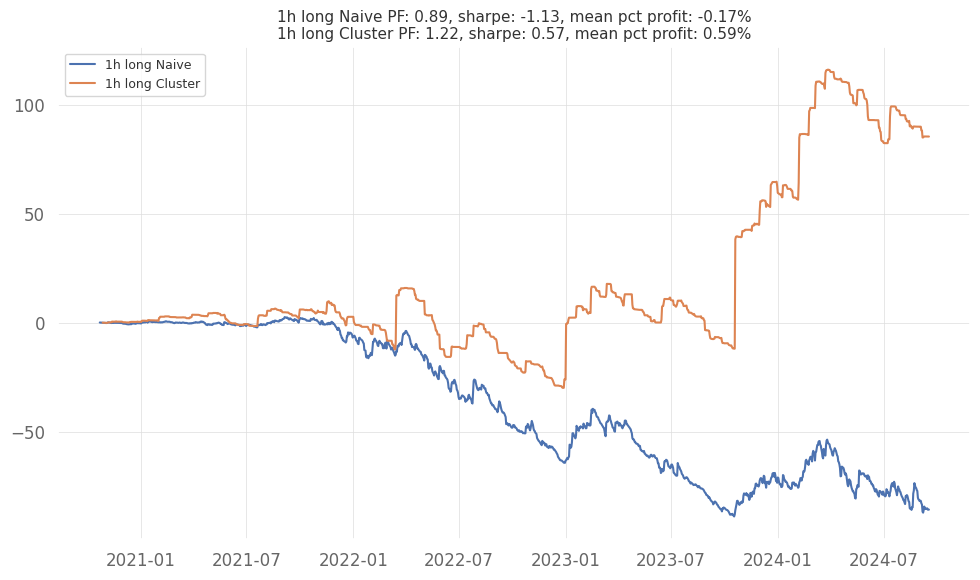

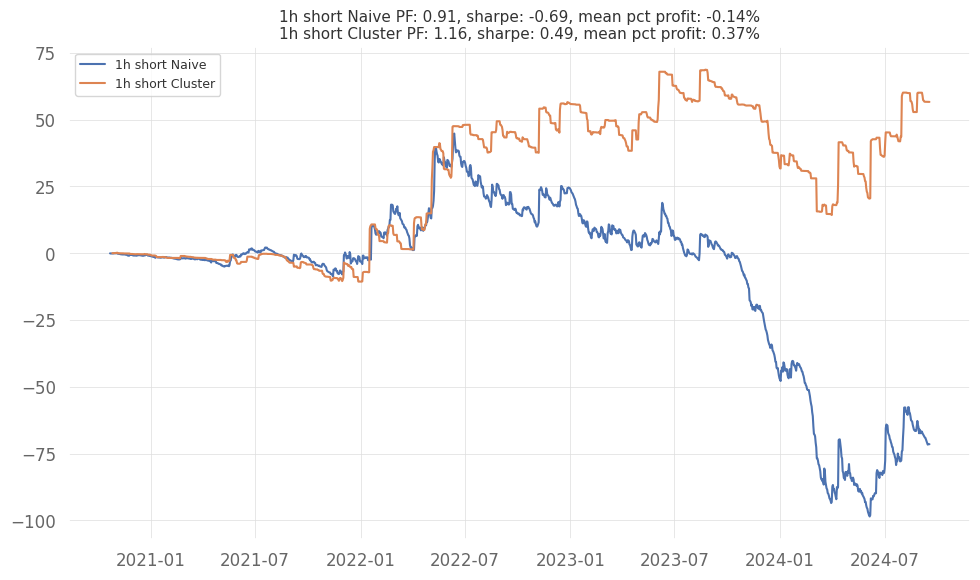

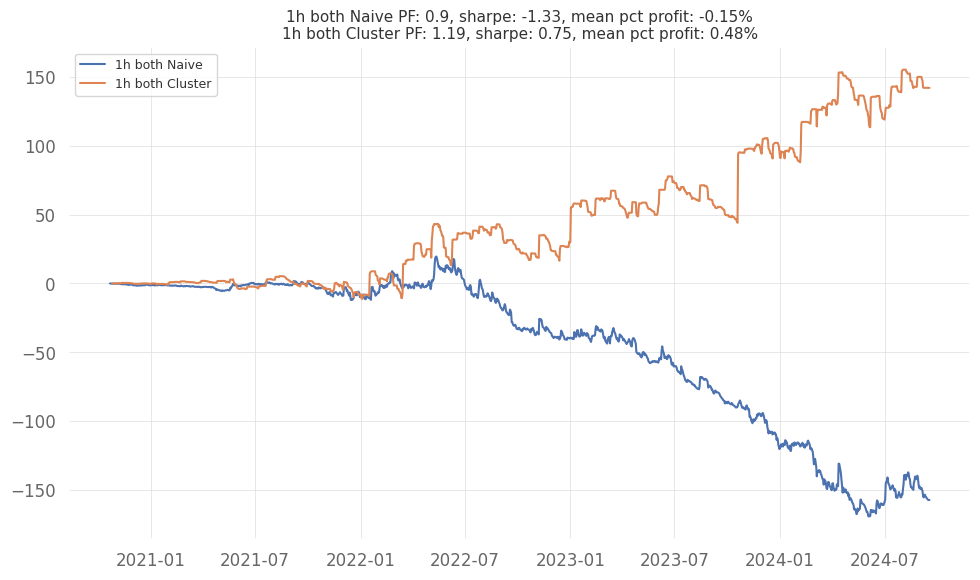

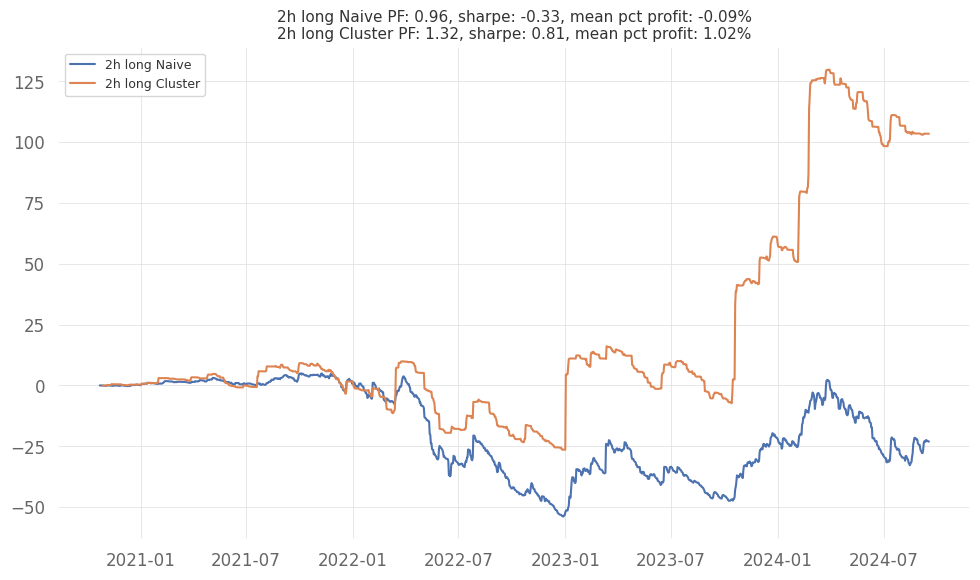

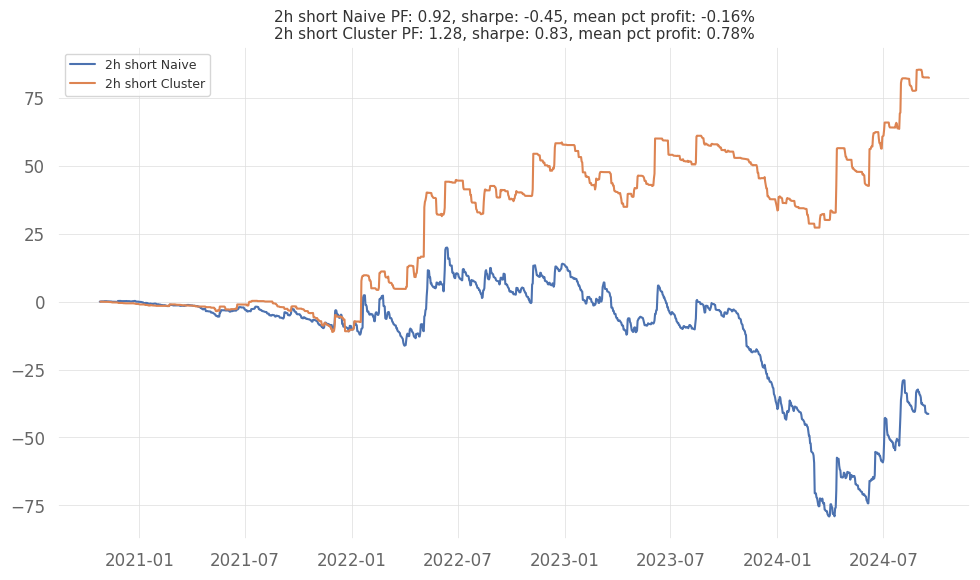

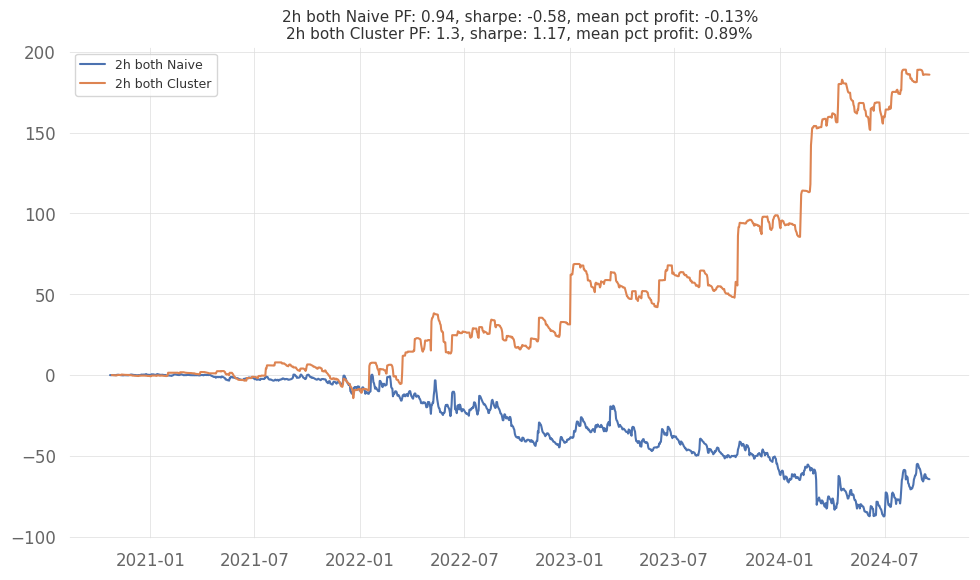

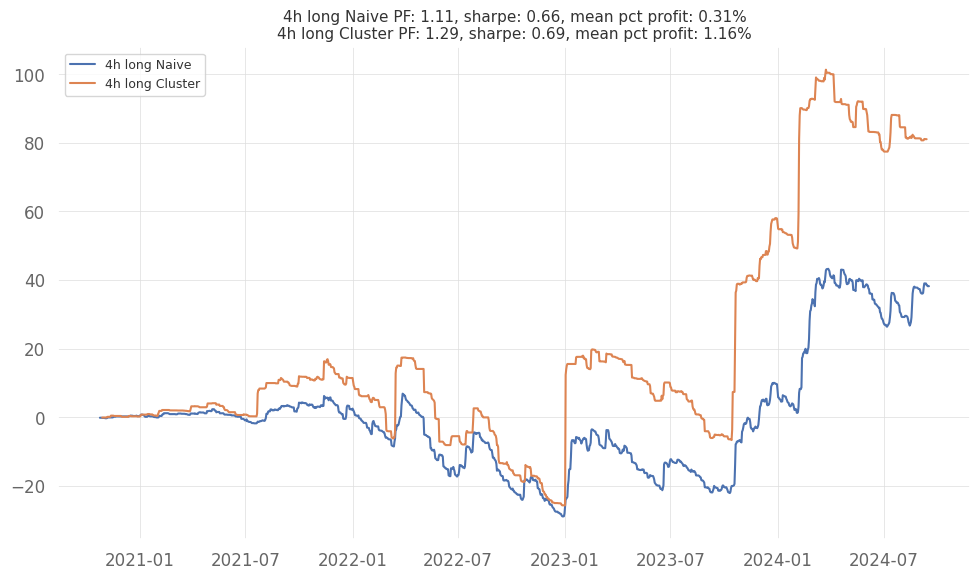

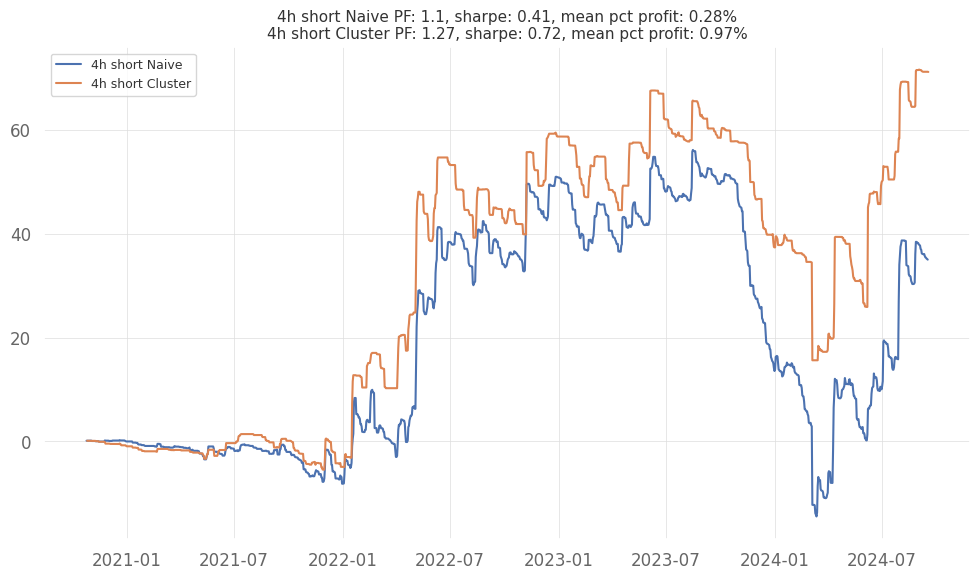

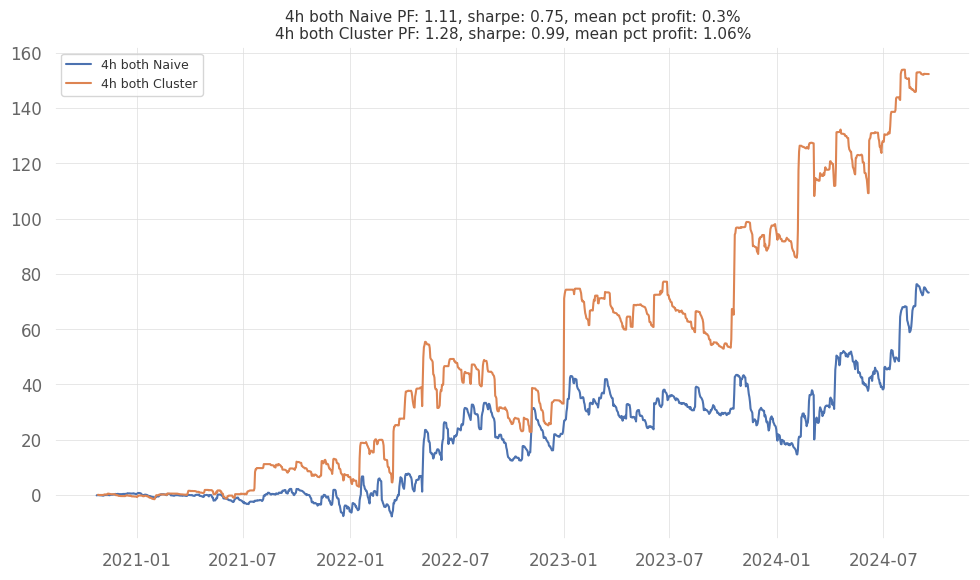

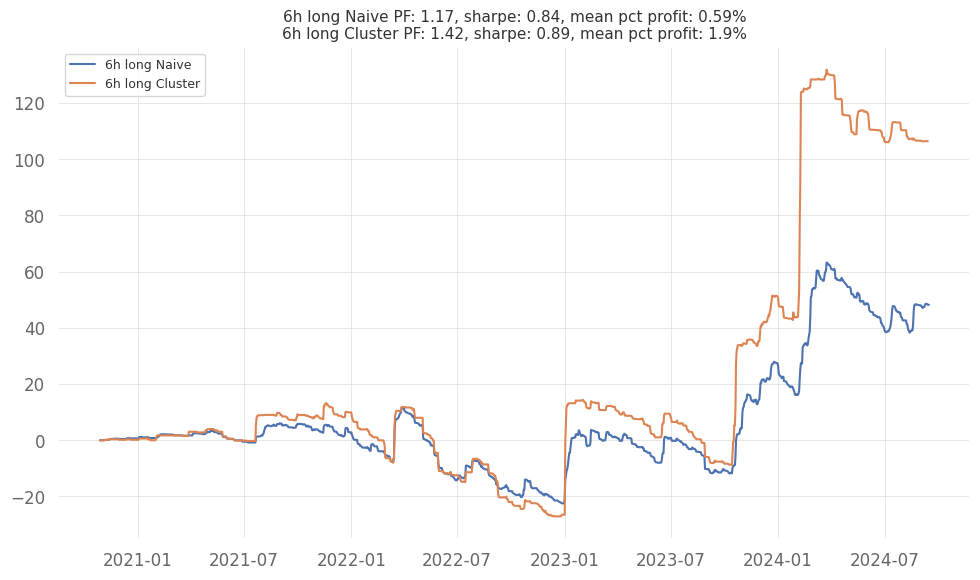

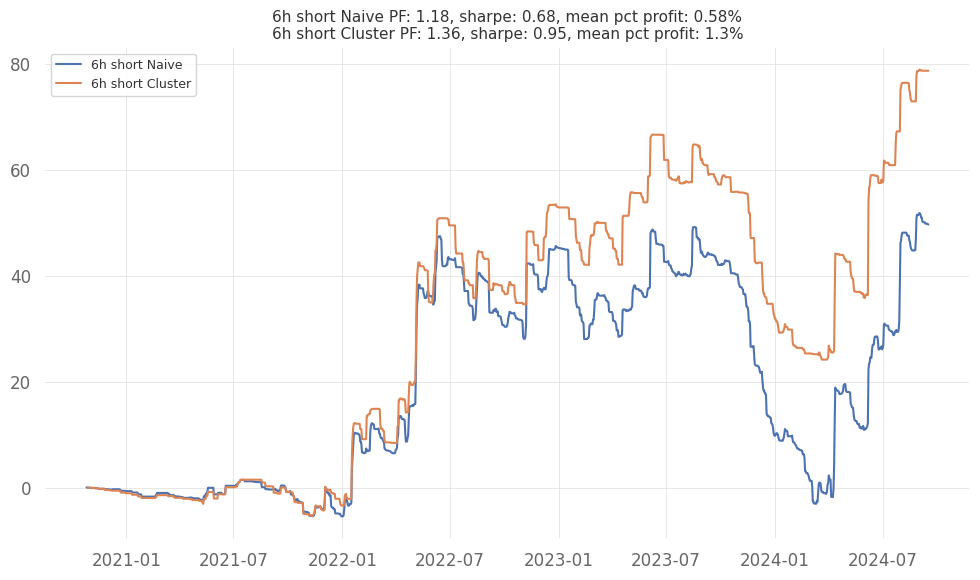

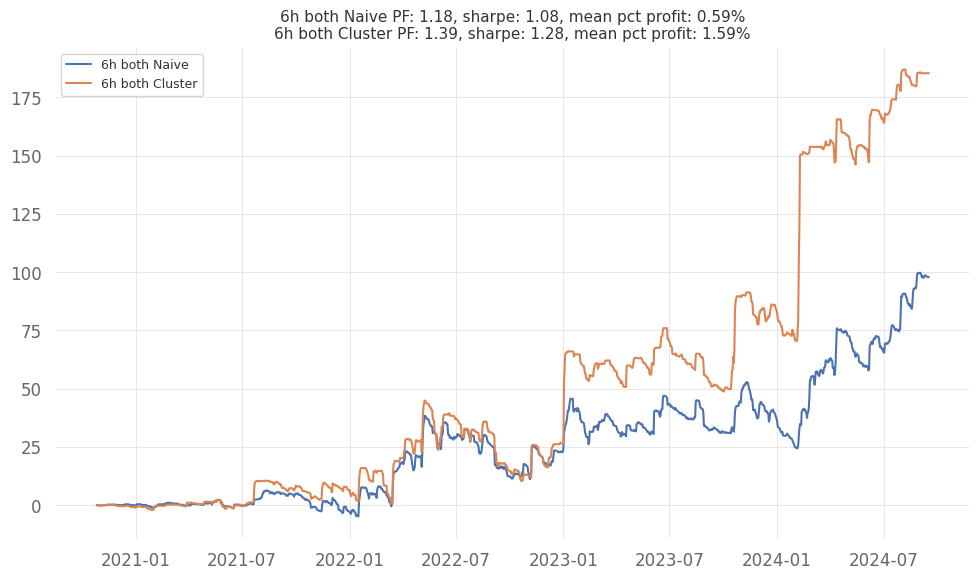

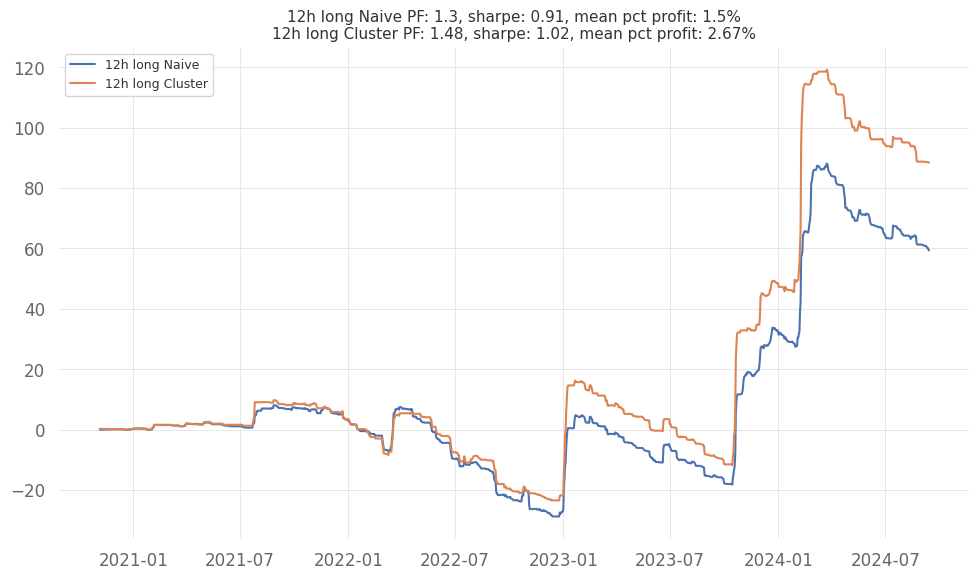

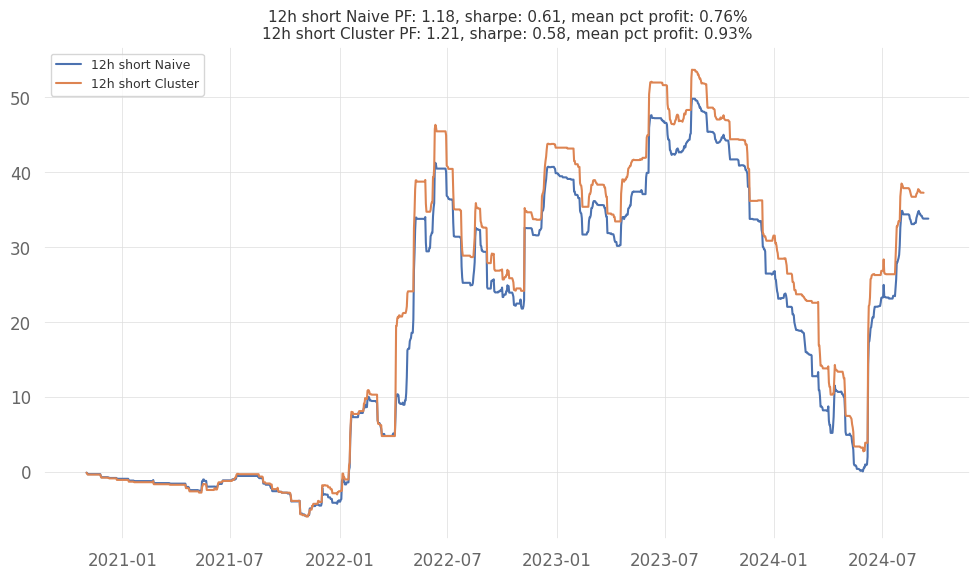

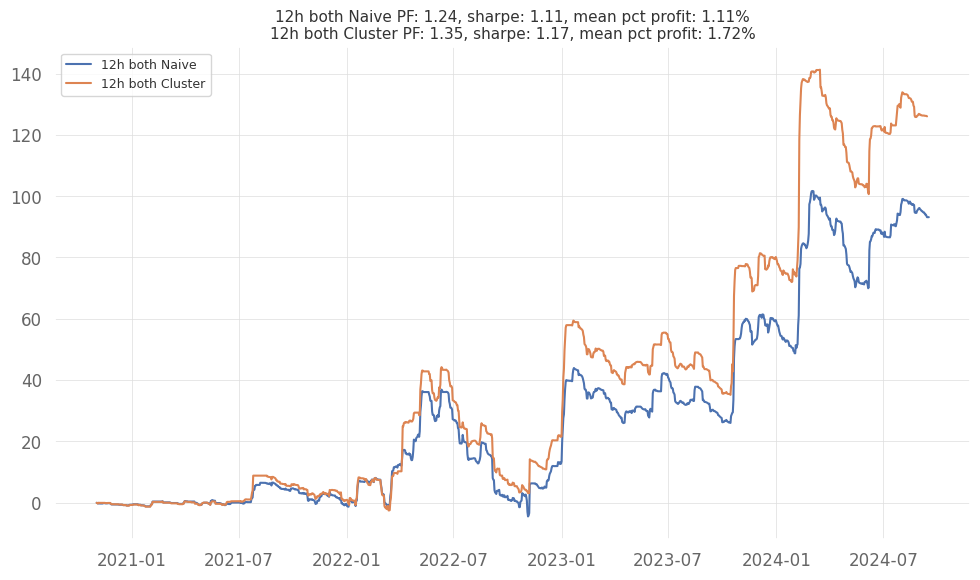

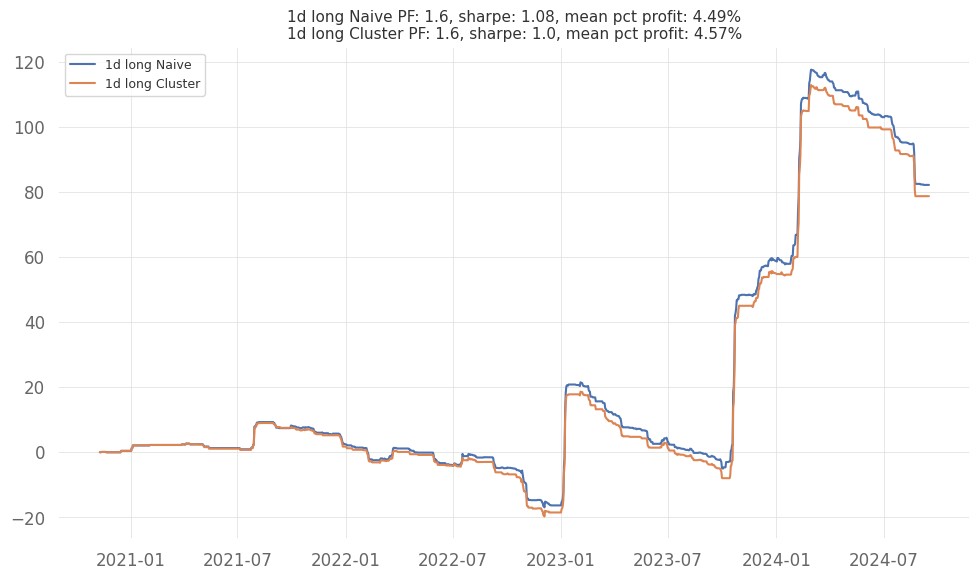

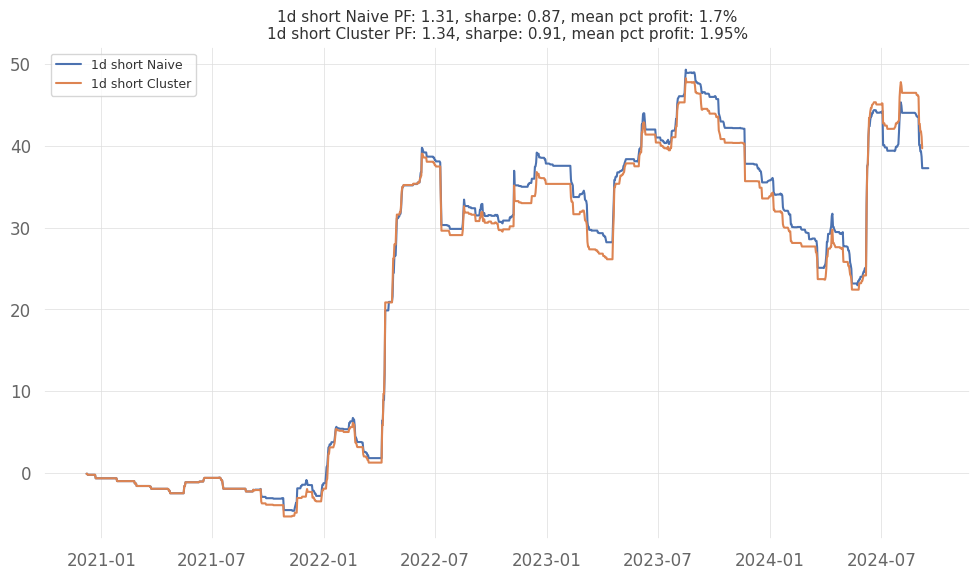

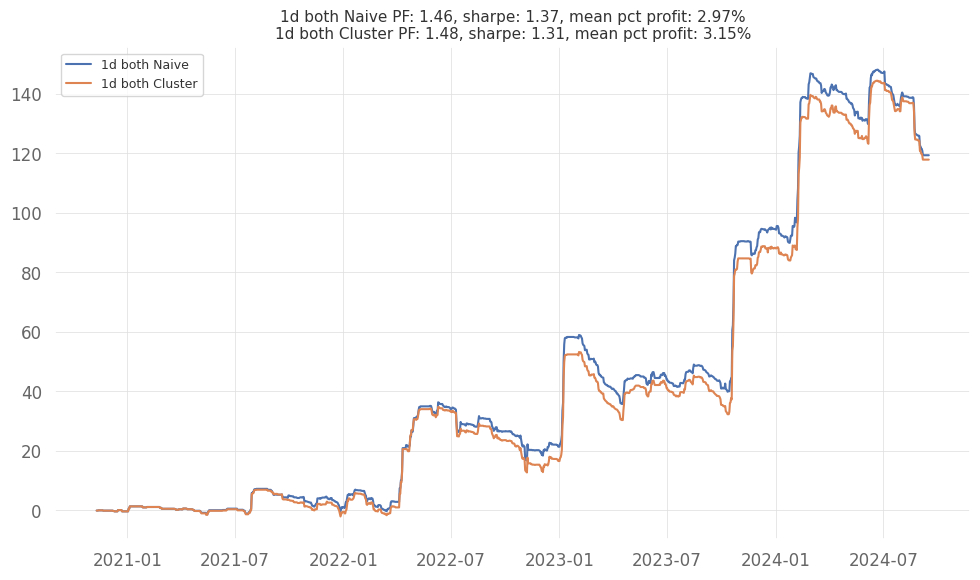

In [ ]:
bt_helpers.plot_backtest_results(bt_results)

Plus j'ai de données, mieux le modèle fonctionne. Cela donne la possibilité à mon modèle d'apprendre et de superformer. Comment je le vois ? Les graphiques !!!!!

## Windows 7

In [16]:
flattened_results[["win_rate_diff", "avg_candles_dur_diff"]].mean().round(2).to_frame()  # type: ignore

,0
win_rate_diff,1.03
avg_candles_dur_diff,-29.05


In [17]:
flattened_results[["pf_diff", "sharpe_diff"]].mean().round(2).to_frame()  # type: ignore

,0
pf_diff,-0.21
sharpe_diff,-0.50


In [18]:
print("min sharpe to be pass test: ", 0.8)  # noqa: T201
pass_test_df = bt_helpers.get_pass_stress_test_df(strat_names, flattened_results, 0.8)

pass_test_df


min sharpe to be pass test:  0.8


,start_name,nb_pass_test
0,Naive,7
1,Cluster,11


In [19]:
bt_helpers.flattened_results_colorized(flattened_results, "pre-analysis")  # type: ignore

,Direction,Timeframe,sum_nb_trades_Cluster,sum_nb_trades_Naive,sum_nb_trades_diff,win_rate_Cluster,win_rate_Naive,win_rate_diff,avg_candles_dur_Cluster,avg_candles_dur_Naive,avg_candles_dur_diff
3,both,1d,3729.00,4046.00,317.00,40.00,39.47,-0.53,18.97,17.19,-1.78
4,long,1d,1672.00,1844.00,172.00,31.25,31.58,0.33,17.72,15.61,-2.12
5,short,1d,2057.00,2202.00,145.00,50.00,47.83,-2.17,19.98,18.51,-1.46
0,both,12h,6790.00,8492.00,1702.00,37.23,37.93,0.70,22.83,16.40,-6.44
1,long,12h,3191.00,4020.00,829.00,30.00,33.33,3.33,23.12,15.49,-7.63
2,short,12h,3606.00,4472.00,866.00,43.59,42.86,-0.73,22.57,17.22,-5.36
15,both,6h,10065.00,16780.00,6715.00,36.80,37.39,0.60,34.44,16.73,-17.72
16,long,6h,4866.00,8213.00,3347.00,30.00,33.33,3.33,35.75,15.88,-19.87
17,short,6h,5207.00,8567.00,3360.00,43.06,40.30,-2.76,33.22,17.54,-15.68
12,both,4h,12196.00,24882.00,12686.00,37.05,37.28,0.23,43.36,17.02,-26.34


In [20]:
bt_helpers.flattened_results_colorized(flattened_results, "results")  # type: ignore

,Direction,Timeframe,pf_Cluster,pf_Naive,pf_diff,sharpe_Cluster,sharpe_Naive,sharpe_diff
3,both,1d,1.51,1.46,-0.05,1.34,1.37,0.03
4,long,1d,1.68,1.60,-0.08,1.06,1.08,0.01
5,short,1d,1.33,1.31,-0.03,0.84,0.87,0.03
0,both,12h,1.31,1.24,-0.07,0.98,1.11,0.13
1,long,12h,1.41,1.30,-0.11,0.89,0.91,0.02
2,short,12h,1.20,1.18,-0.02,0.47,0.61,0.15
15,both,6h,1.34,1.18,-0.17,1.02,1.08,0.06
16,long,6h,1.43,1.17,-0.25,0.82,0.84,0.02
17,short,6h,1.25,1.18,-0.07,0.60,0.68,0.07
12,both,4h,1.42,1.11,-0.31,1.34,0.75,-0.59


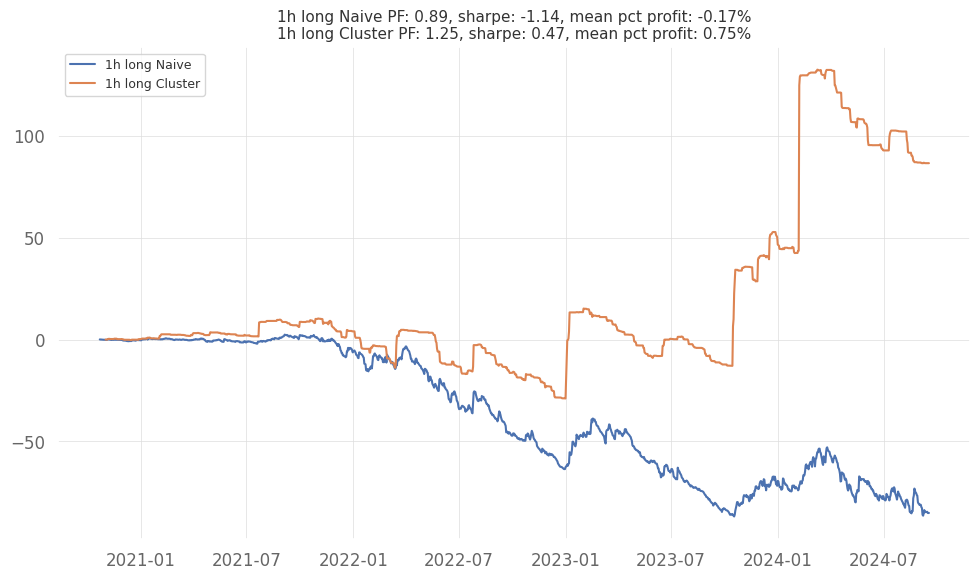

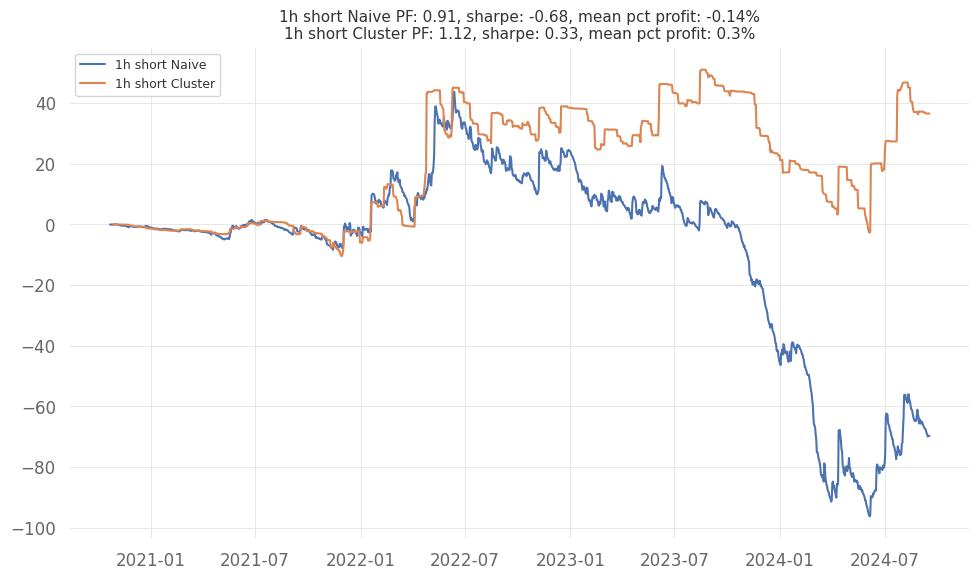

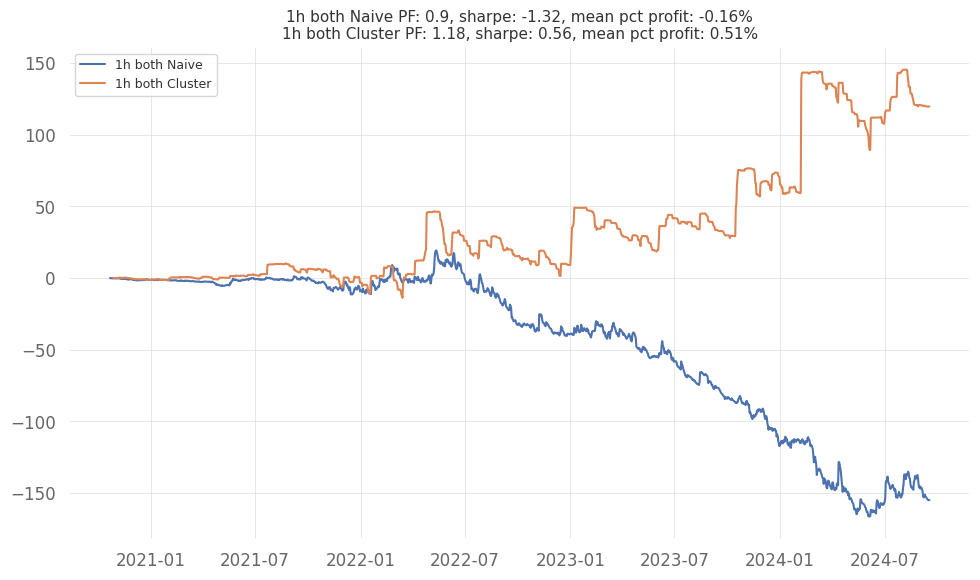

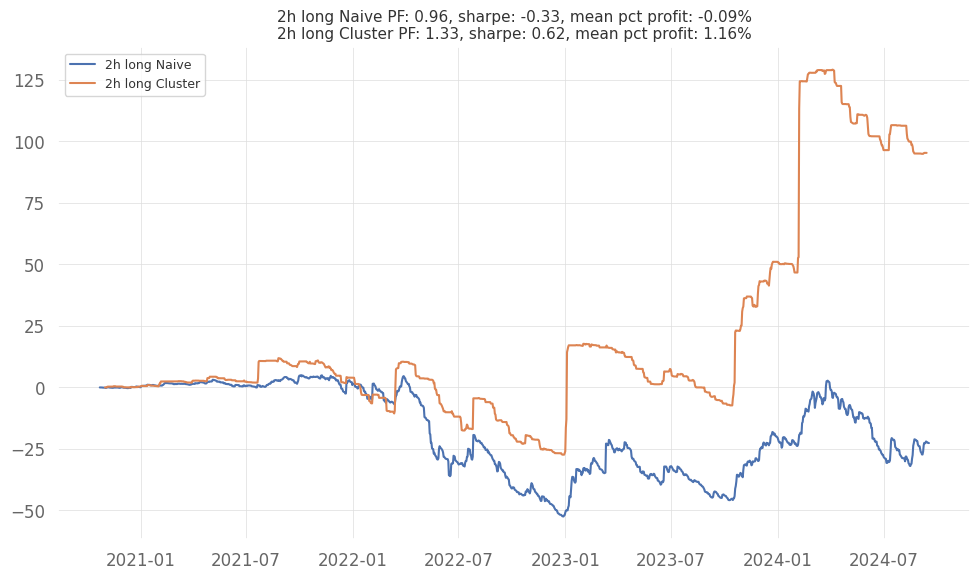

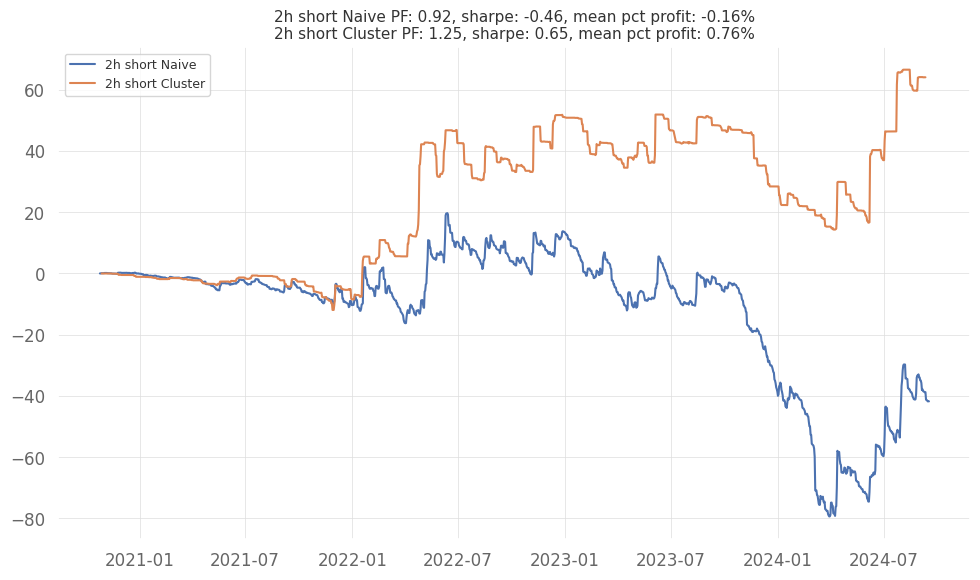

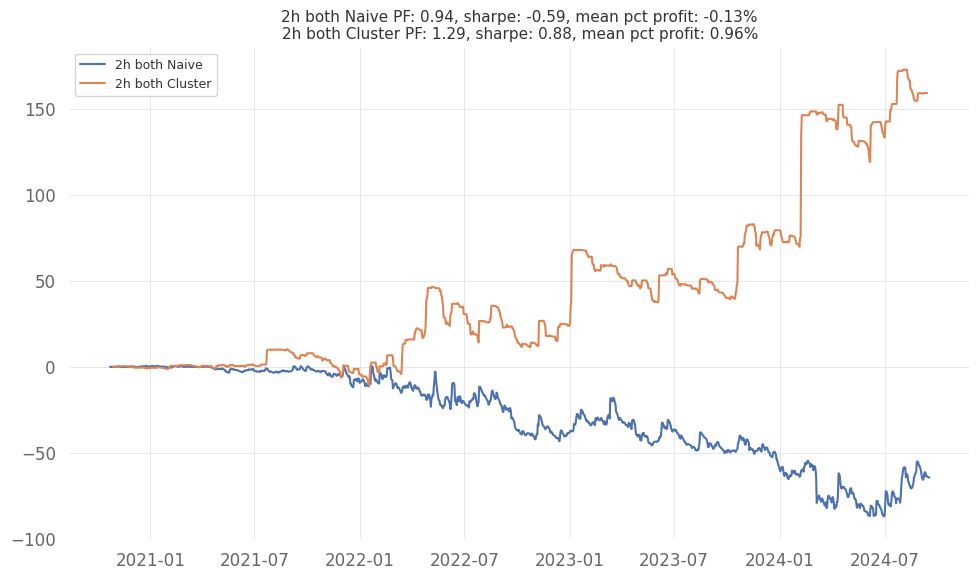

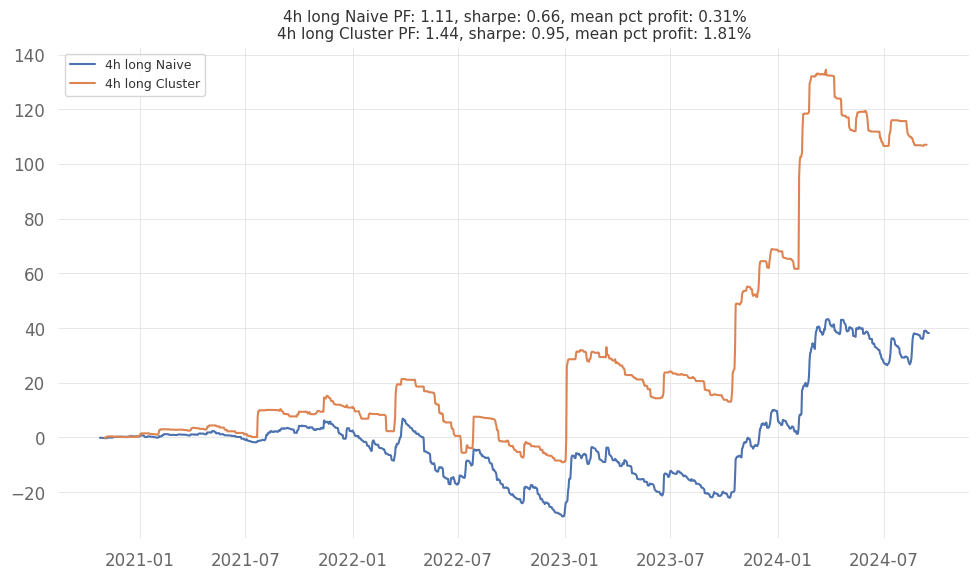

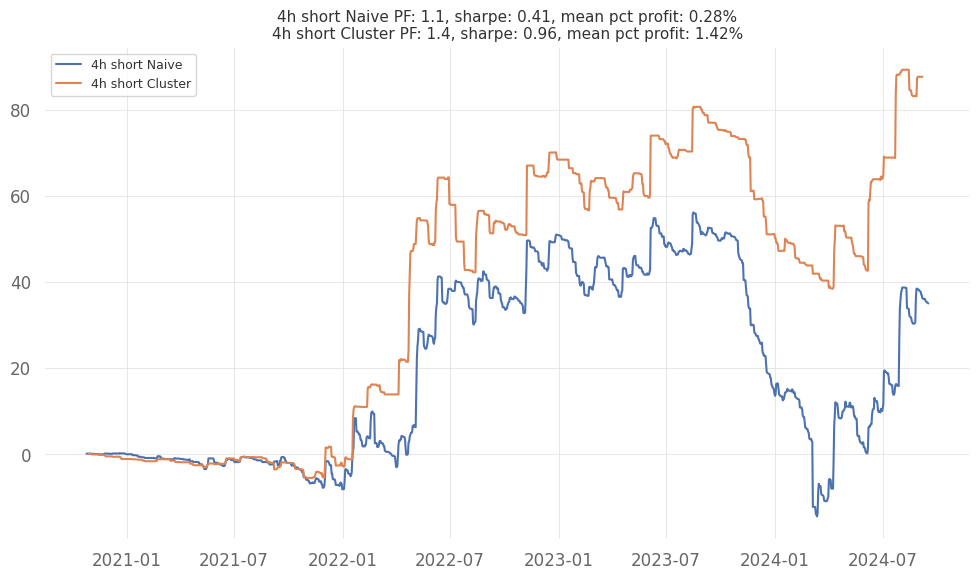

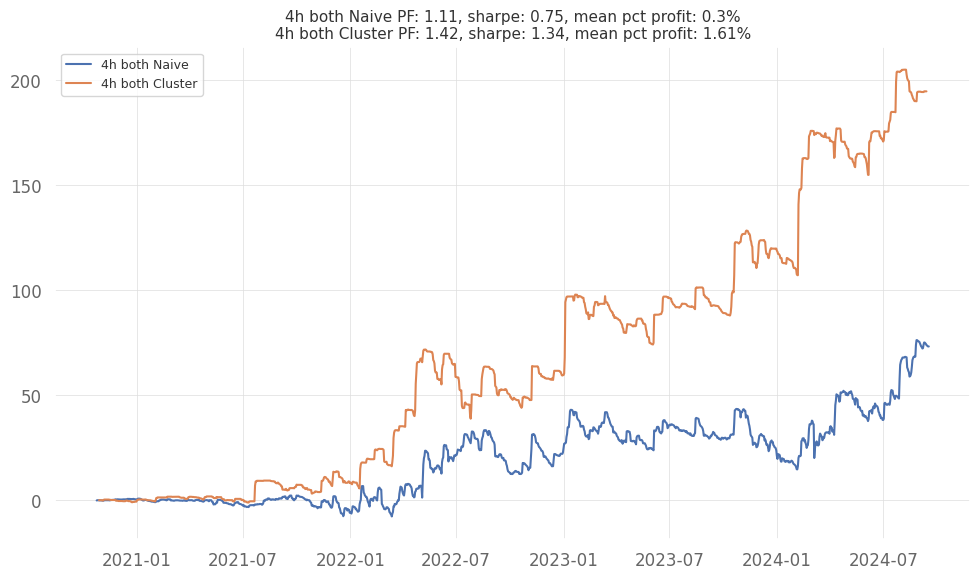

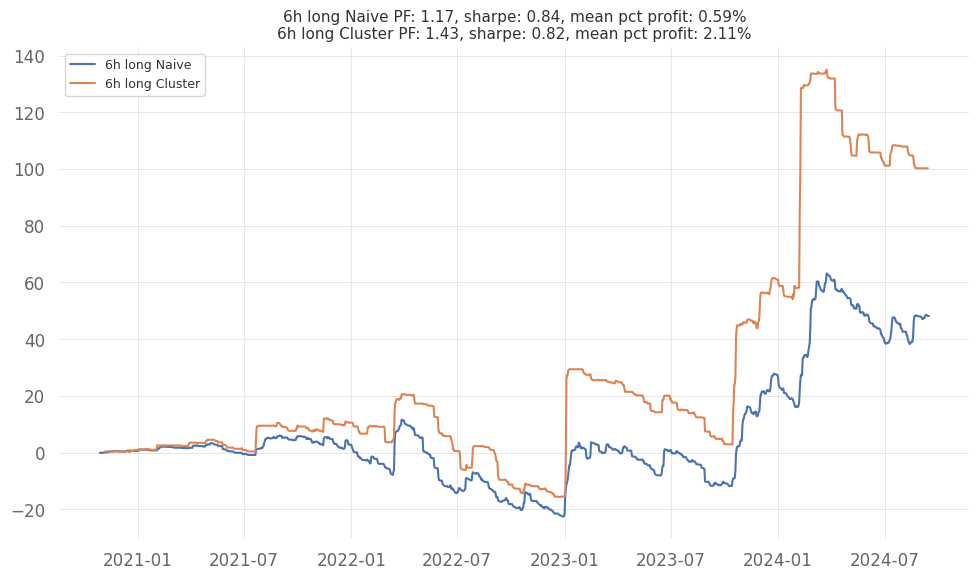

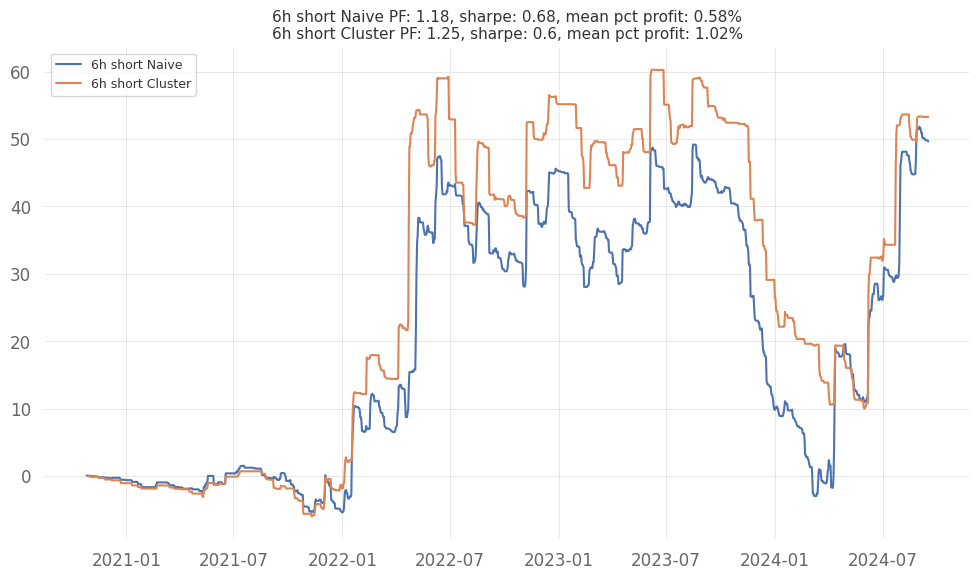

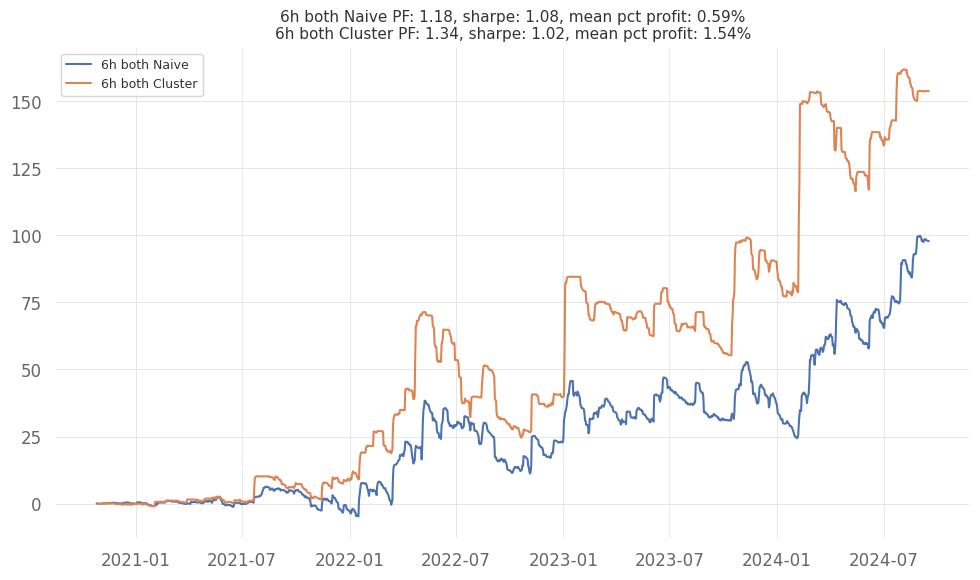

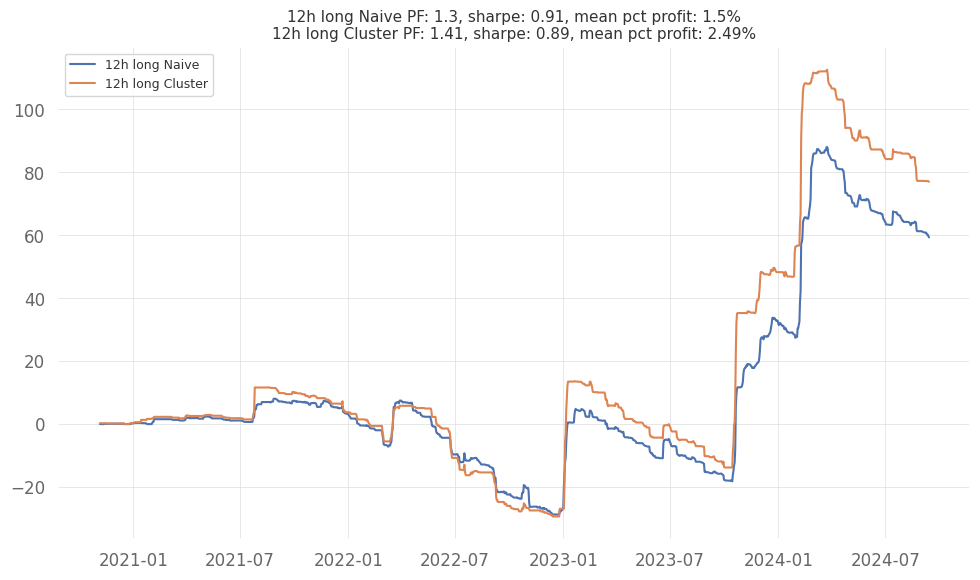

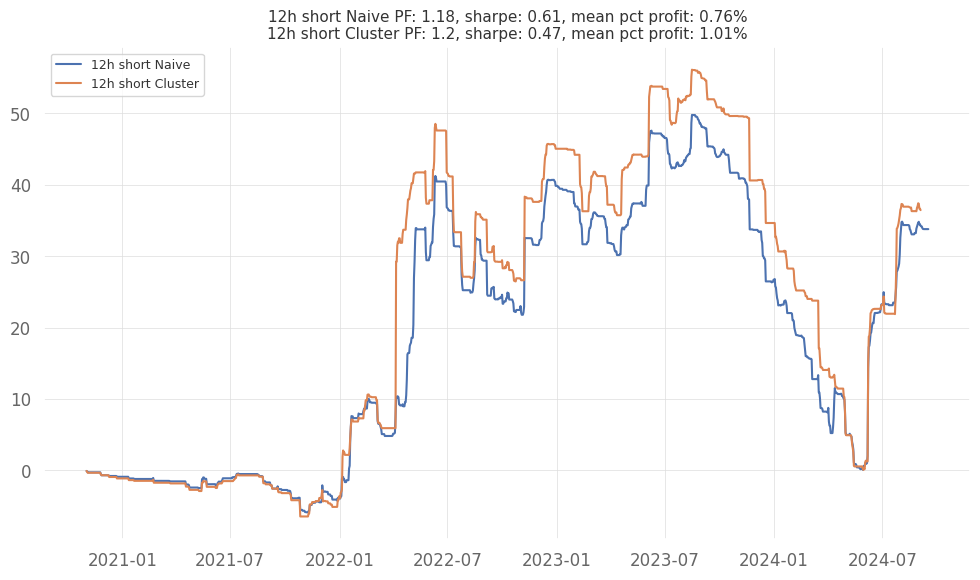

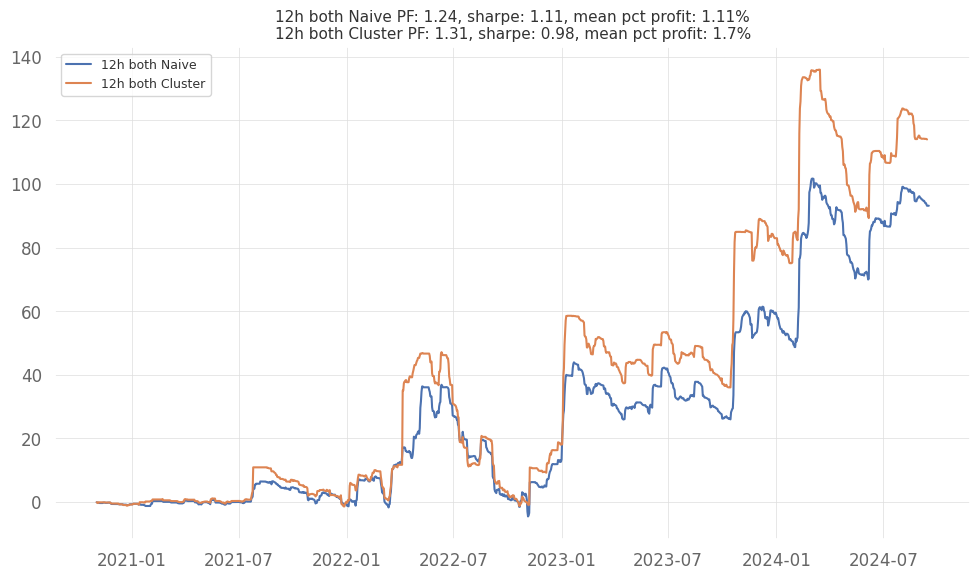

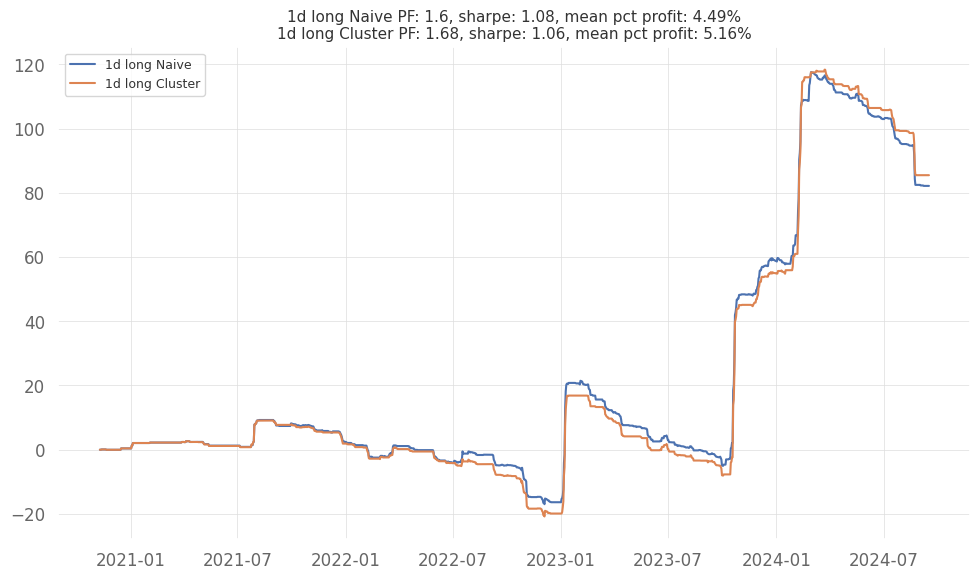

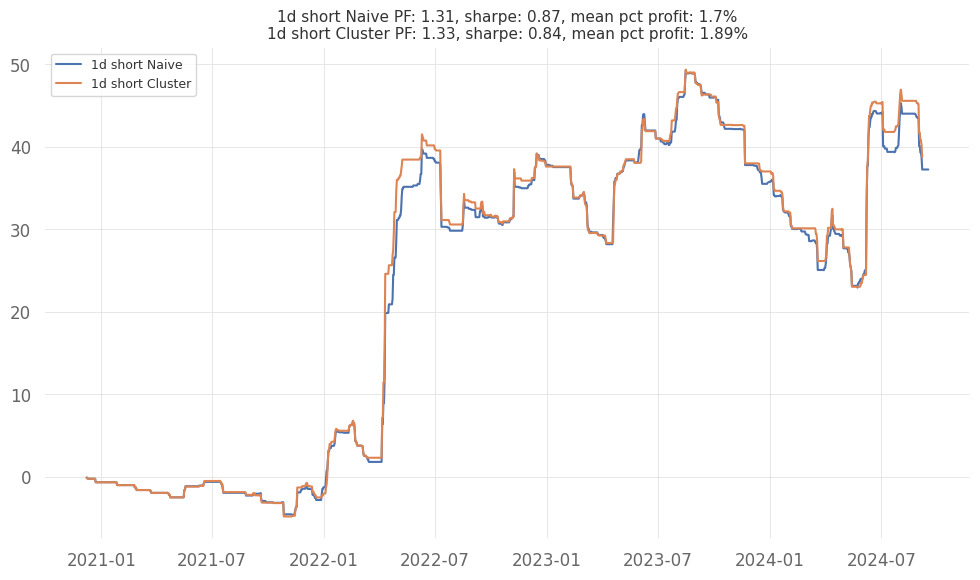

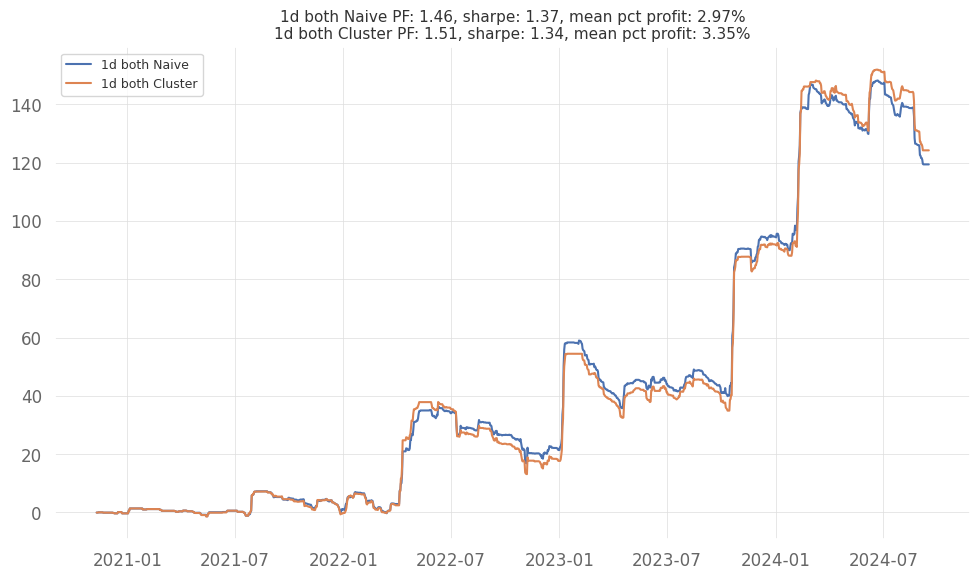

In [21]:
bt_helpers.plot_backtest_results(bt_results)

## Conclusion

Certaines granularités affichent de meilleures performances avec une fenêtre de calcul de 7 jours, notamment pour les intervalles de temps de 4h et 6h. En revanche, pour les intervalles de 1h et 2h, une fenêtre de 5 jours semble plus adaptée. Les intervalles de 12h et 1 jour ne montrent pas de préférence marquée entre ces deux fenêtres. Cette variation de sensibilité aux fenêtres de calcul est compréhensible, car une fenêtre trop longue sur des granularités fines risque de faire passer à côté de signaux potentiels.

À noter que l'utilisation de fenêtres inférieures à 2 jours ou supérieures à 30 jours entraîne des résultats nettement dégradés.